In [1]:
%load_ext autoreload
%autoreload 2

In [24]:

from helpers import load_result_table,plot_metric_matrix, plot_mm_grid
table = load_result_table(formatter="{AU}_{EU}_1",epoch=500,
                           loop_params = {
                            "AU": ["softmax", "ssn", "diffusion", "prob_unet"],
                            "EU": ["swag", "dropout", "swag_diag"]
                },
                save_path = "/home/jloch/Desktop/diff/luzern/values/saves/chaksu128/test_results/",
                aggregation_type = "patch_level")
print(table.shape)
print(table.columns)

(12, 21)
Index(['AU', 'EU', 'version', 'val_dice', 'val_ged', 'val_ged_bma', 'id_dice',
       'id_ged', 'id_ged_bma', 'EU_ncc', 'AU_ncc', 'TU_ncc', 'EU_ace',
       'AU_ace', 'TU_ace', 'EU_auc', 'AU_auc', 'TU_auc', '(AU-EU)_ncc',
       '(EU-AU)_auc', '(min(AU,EU)-TU)_ace'],
      dtype='object')


In [25]:
max_col_chars = max([len(col) for col in table.columns])
for col in table.columns:
    print(f"{col:{max_col_chars}} : {type(table[col].iloc[0])} ")

AU                  : <class 'str'> 
EU                  : <class 'str'> 
version             : <class 'str'> 
val_dice            : <class 'numpy.float64'> 
val_ged             : <class 'numpy.float64'> 
val_ged_bma         : <class 'numpy.float64'> 
id_dice             : <class 'numpy.float64'> 
id_ged              : <class 'numpy.float64'> 
id_ged_bma          : <class 'numpy.float64'> 
EU_ncc              : <class 'dict'> 
AU_ncc              : <class 'dict'> 
TU_ncc              : <class 'dict'> 
EU_ace              : <class 'dict'> 
AU_ace              : <class 'dict'> 
TU_ace              : <class 'dict'> 
EU_auc              : <class 'dict'> 
AU_auc              : <class 'dict'> 
TU_auc              : <class 'dict'> 
(AU-EU)_ncc         : <class 'dict'> 
(EU-AU)_auc         : <class 'dict'> 
(min(AU,EU)-TU)_ace : <class 'dict'> 


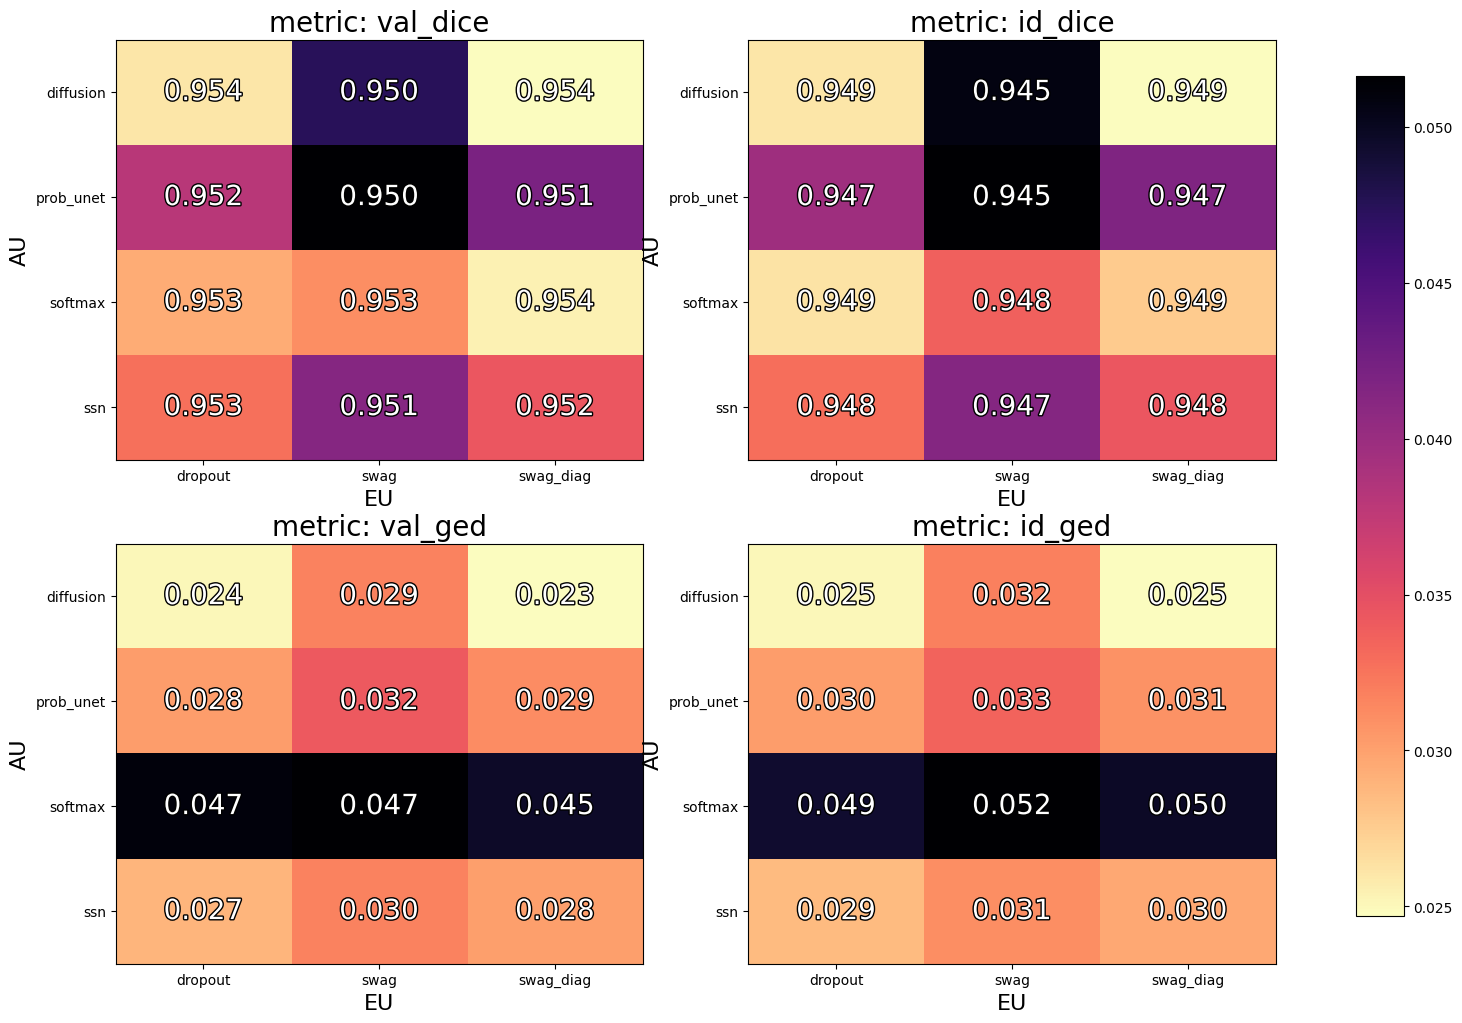

In [26]:
# RAW METRICS
from helpers import plot_metric_matrix, plot_mm_grid
out = plot_mm_grid(table)

# chaksu

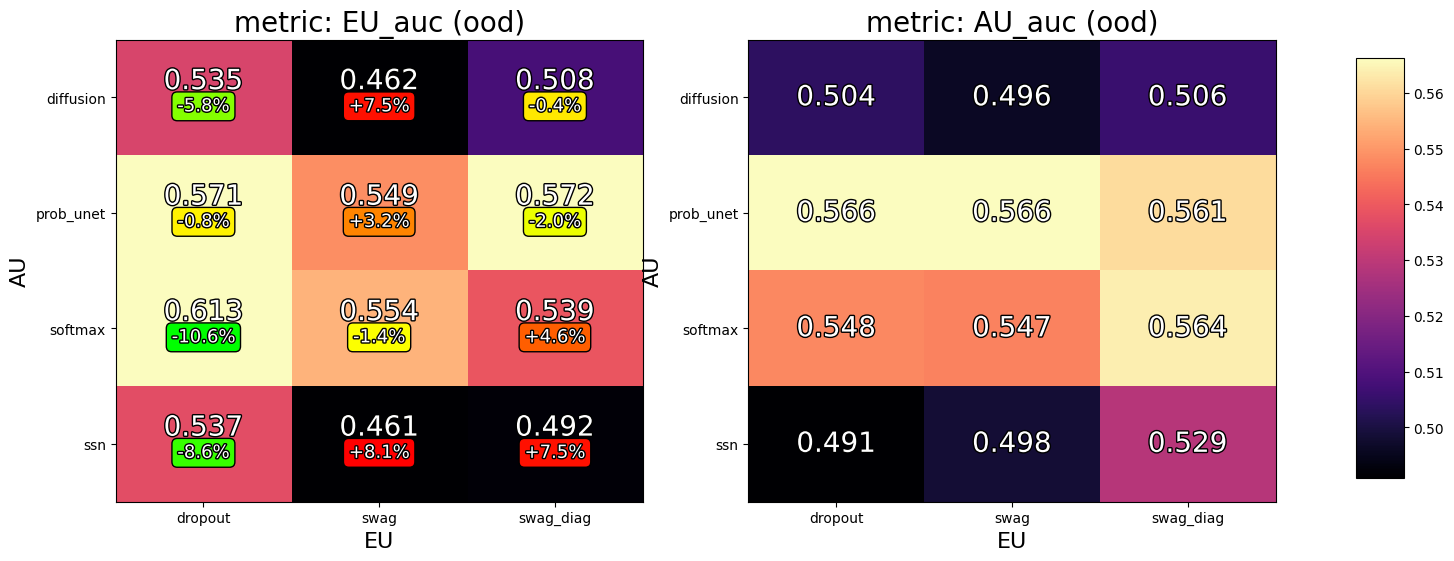

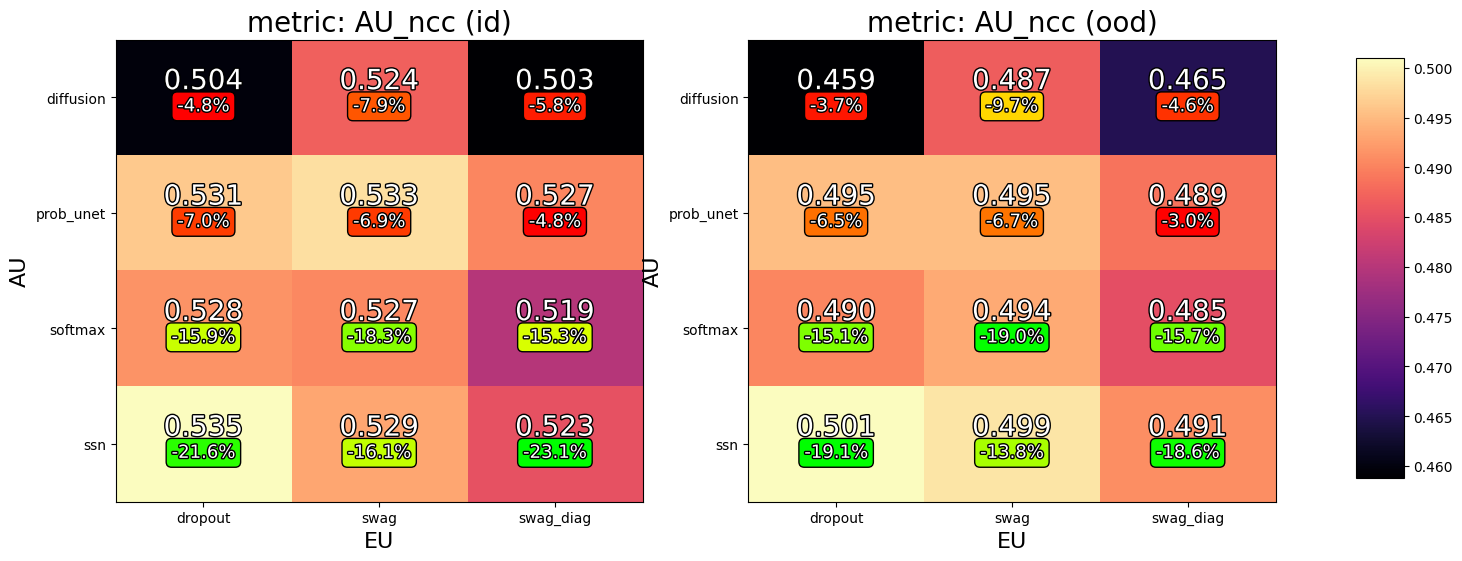

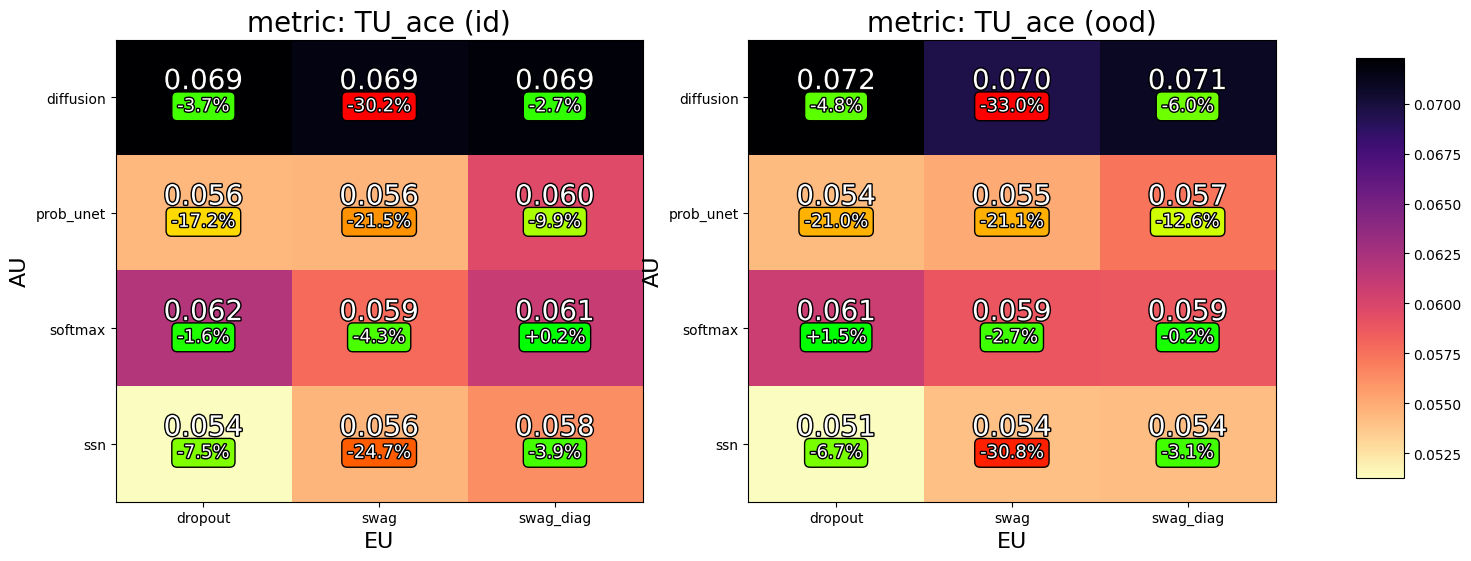

In [27]:
# UQ chaksu64
from helpers import plot_metric_matrix, plot_mm_grid
#plot_metric_matrix(table,metric="EU_auc",reldiff="(EU-AU)_auc",subkey="ood",cbar_keys=["EU_auc","AU_auc"])
plot_mm_grid(table,kwarg_grid=[[{"metric":"EU_auc","reldiff":"(EU-AU)_auc","subkey":"ood","cbar_keys": ["EU_auc","AU_auc"]},
                              {"metric":"AU_auc","subkey":"ood", "cbar_keys": ["EU_auc","AU_auc"]}]])
plot_mm_grid(table,kwarg_grid=[[{"metric":"AU_ncc","reldiff":"(AU-EU)_ncc","subkey":"id"},
                              {"metric":"AU_ncc","reldiff":"(AU-EU)_ncc","subkey":"ood"}]])
#plot_metric_matrix(table,metric="TU_ace",reldiff="(min(AU,EU)-TU)_ace",subkey="ood",cbar_keys=["TU_ace"])
plot_mm_grid(table,kwarg_grid=[[{"metric":"TU_ace","reldiff":"(min(AU,EU)-TU)_ace","subkey":"id"},
                                {"metric":"TU_ace","reldiff":"(min(AU,EU)-TU)_ace","subkey":"ood"}]]);

# aggr study chaksu

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


matrices = {}
ood_types = ["ood"]
aggr_types = ['patch_level', 'image_level', 'threshold', 'area_normalized', 'border_normalized']

from helpers import load_result_table,plot_metric_matrix, plot_mm_grid
for aggr in aggr_types:
    table = load_result_table(swap_AU_EU=False,
                            formatter="{AU}_{EU}_1",epoch=500,
                            loop_params = {
                                "AU": ["softmax", "ssn", "diffusion", "prob_unet"],
                                "EU": ["swag", "dropout", "swag_diag"]
                    },
                    save_path = "/home/jloch/Desktop/diff/luzern/values/saves/chaksu128/test_results/",
                    aggregation_type = aggr)
    out = plot_metric_matrix(table, metric="AU_auc",reldiff="(EU-AU)_auc",subkey="ood",cbar_keys=["EU_auc"])
    #dont show the figure:
    plt.close()
    matrices[aggr] = out["matrix"]

In [14]:


#make a matrix of lists over aggregation types for each subkey. Each matrix is a 4x3 matrix as a pandas table
#initalize with empty lists
all_matrix = matrices[aggr_types[0]].copy()
#fill the pandas table with empty lists
all_matrix = all_matrix.applymap(lambda x: [])
#fill the matrices with the values from each aggregation type
for aggr in aggr_types:
        for i in range(all_matrix.shape[0]):
            for j in range(all_matrix.shape[1]):
                all_matrix.iloc[i,j].append(matrices[aggr].iloc[i,j])
def gaussnorm(x):
    x = np.array(x)
    return (x - x.mean()) / x.std()
# normalize with gaussian for all lists
all_matrix = all_matrix.applymap(lambda x: gaussnorm(x))


/tmp/ipykernel_201365/378545066.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df,x="aggr",y="value",ax=ax, palette="Set2")


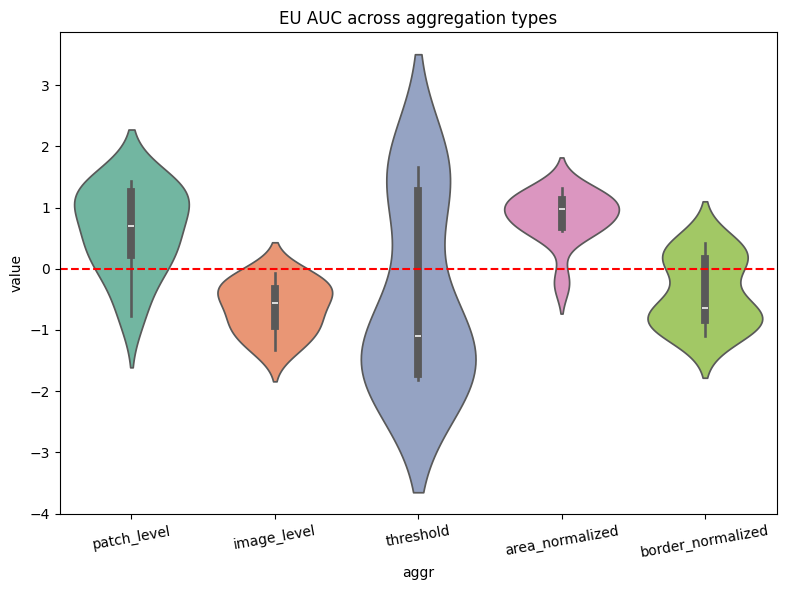

In [15]:


fig,ax = plt.subplots(1, 1, figsize=(8,6))
import seaborn as sns
import pandas as pd
#make a violin plot where each violin is a aggr type. The dataset for the violin is the flattened matrix for each aggr type. The x axis is the aggr type and the y axis is the value of the matrix element. The title is "EU AUC across aggregation types"
#first make a dataframe where each row is a value from the matrix and has a column for the aggr type
df = pd.DataFrame(columns=["aggr","value"])
for aggr_idx,aggr in enumerate(aggr_types):
    values = [item[aggr_idx] for item in all_matrix.values.flatten()]
    df = pd.concat([df,pd.DataFrame({"aggr":[aggr]*len(values),"value":values})], ignore_index=True)
sns.violinplot(data=df,x="aggr",y="value",ax=ax, palette="Set2")
ax.set_title("EU AUC across aggregation types")
#make 0-line
ax.axhline(0, color="red", linestyle="--")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# aggr study

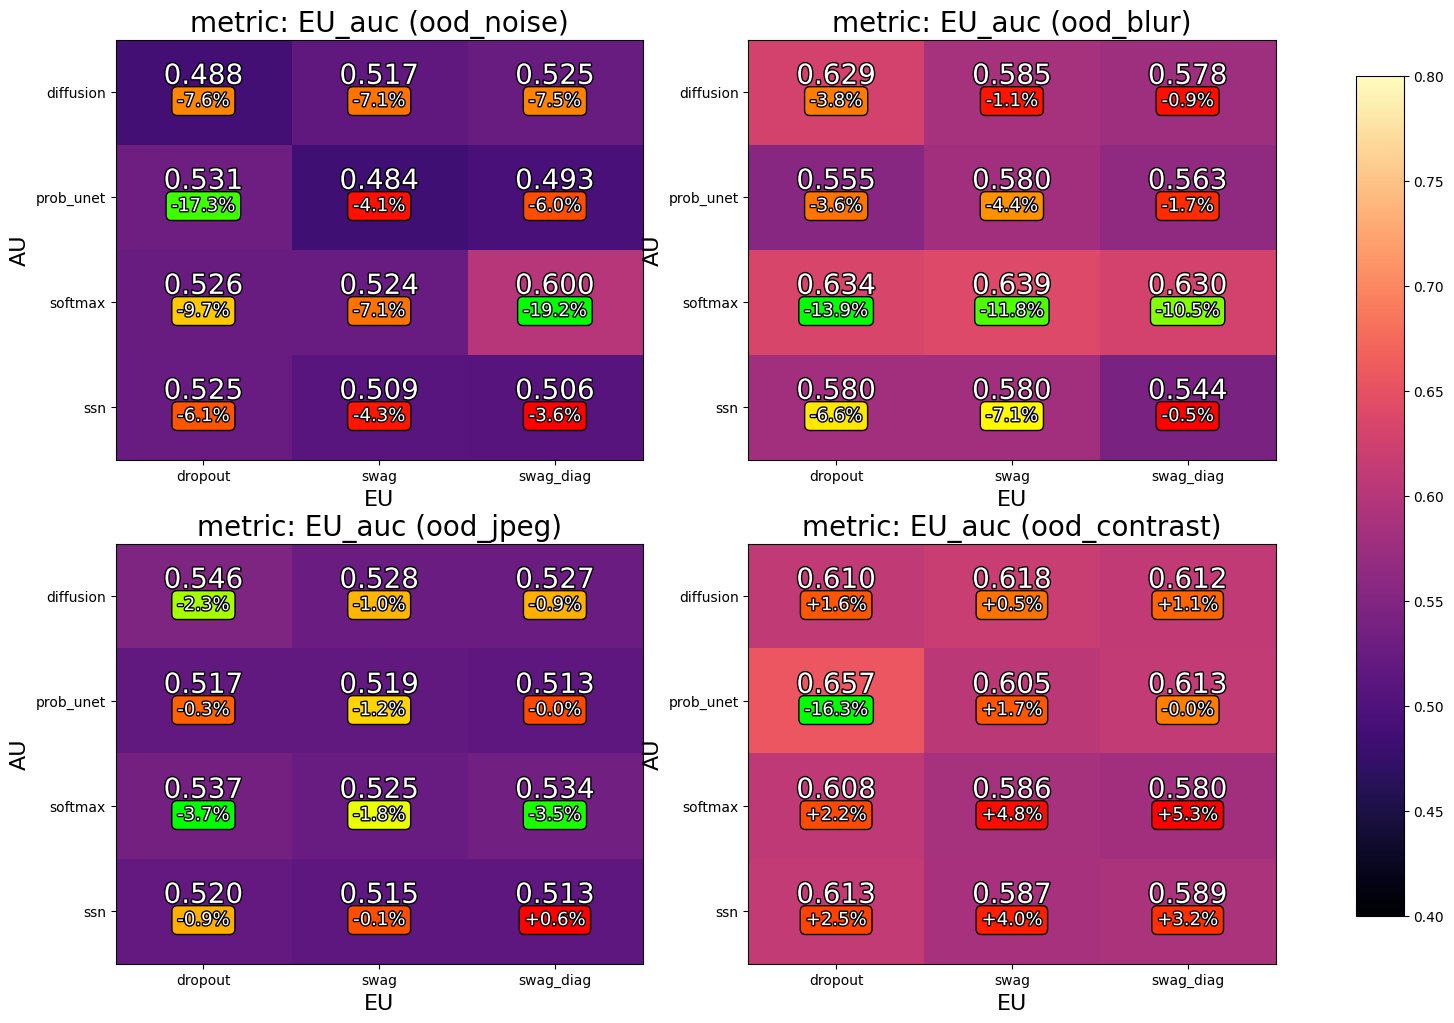

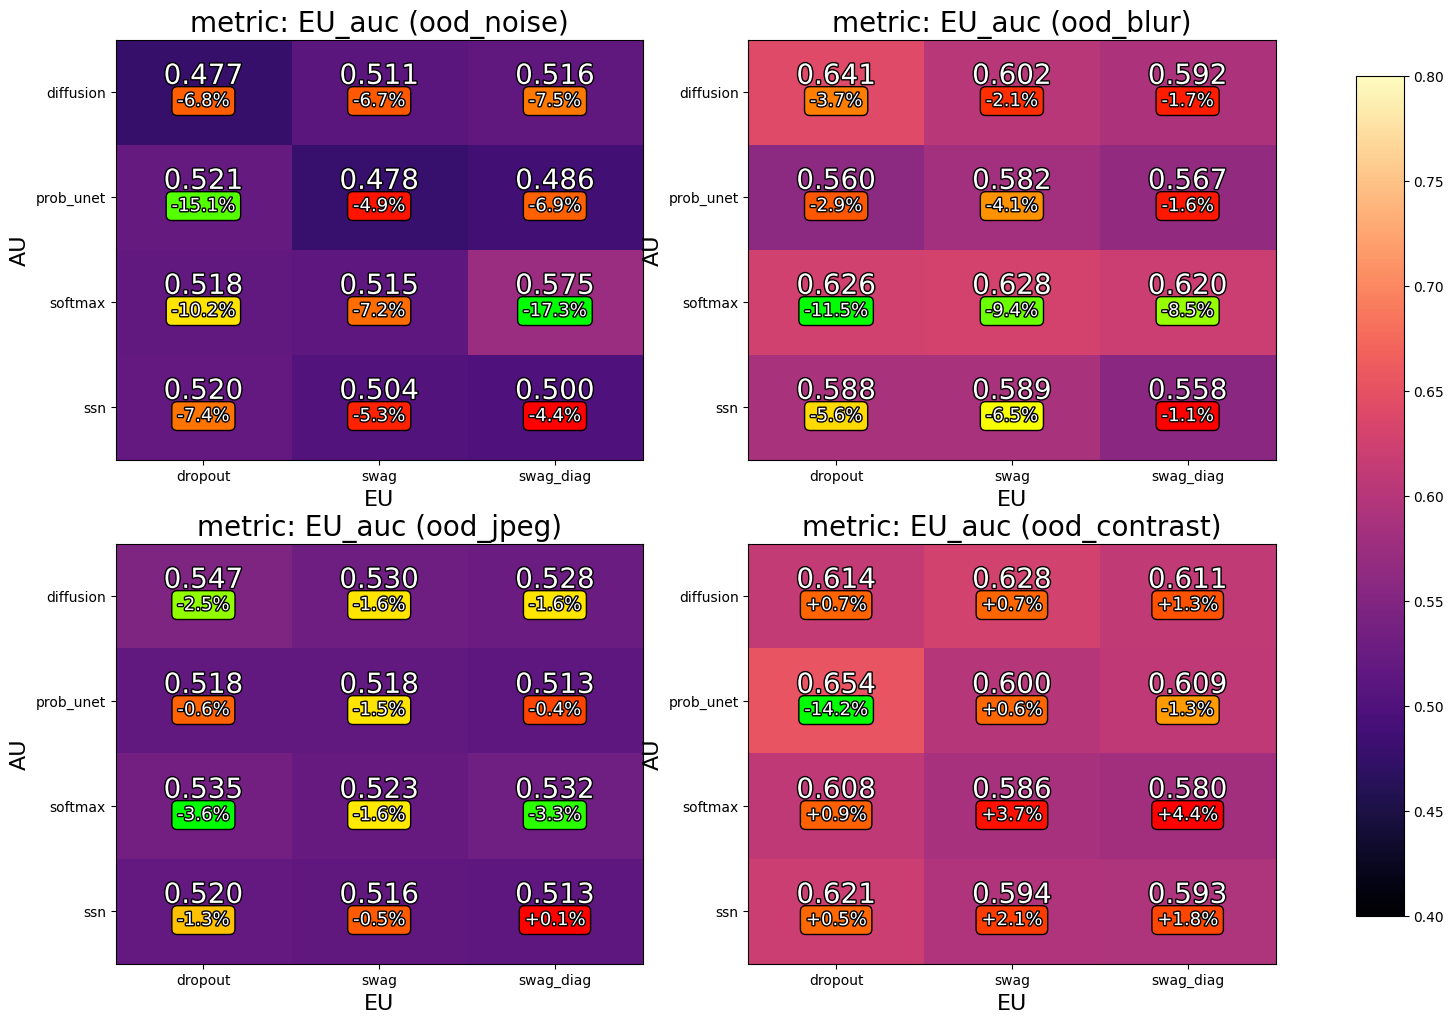

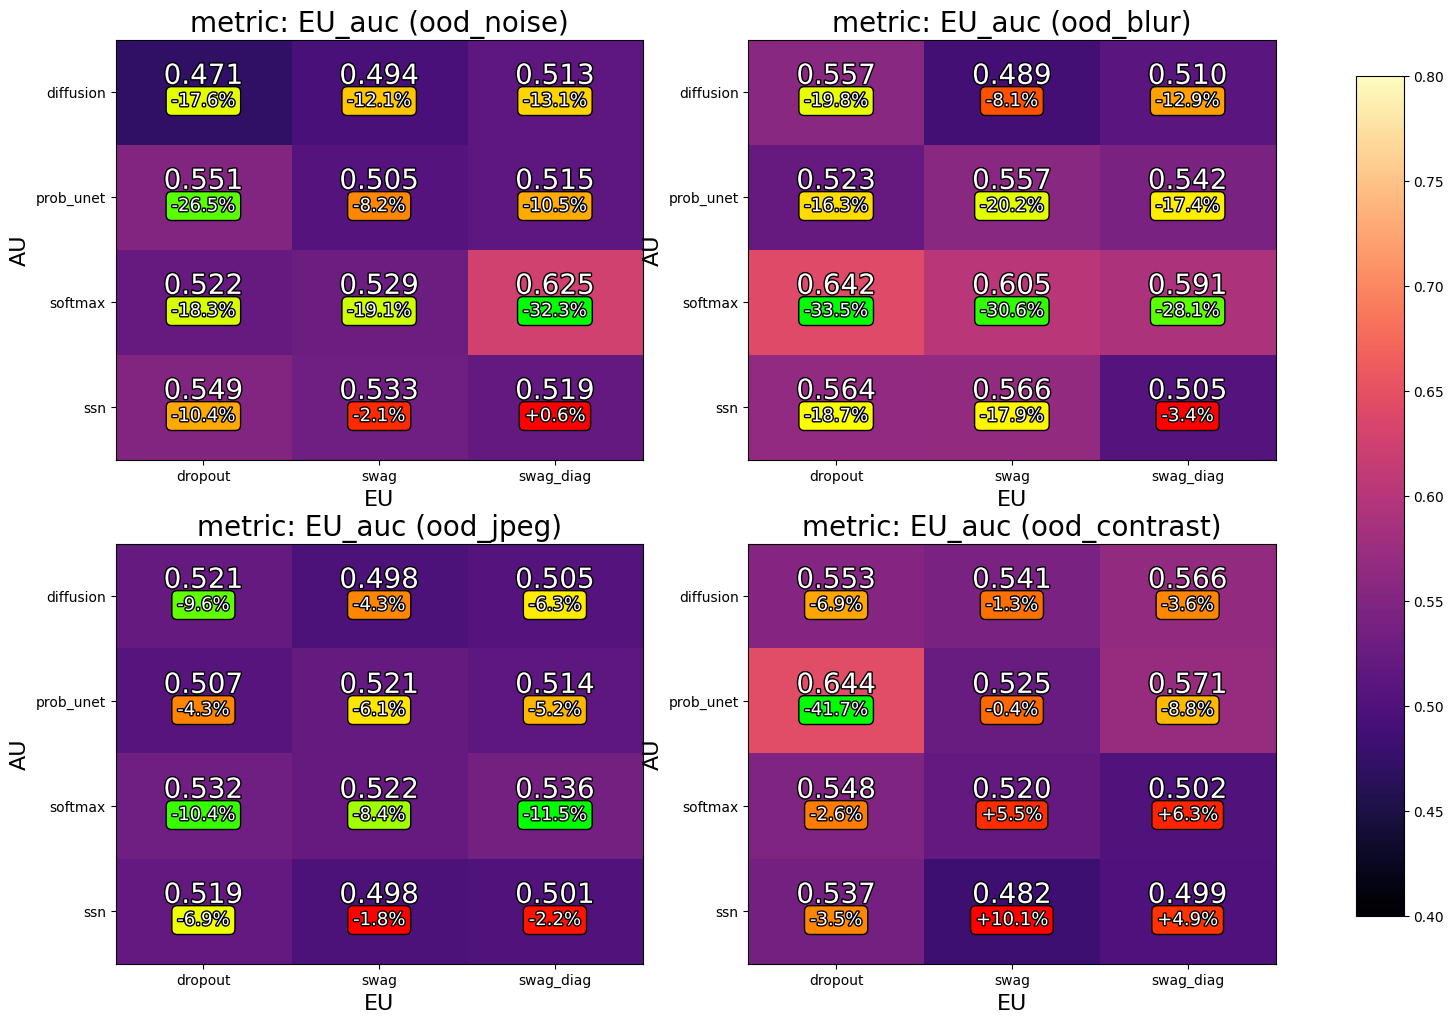

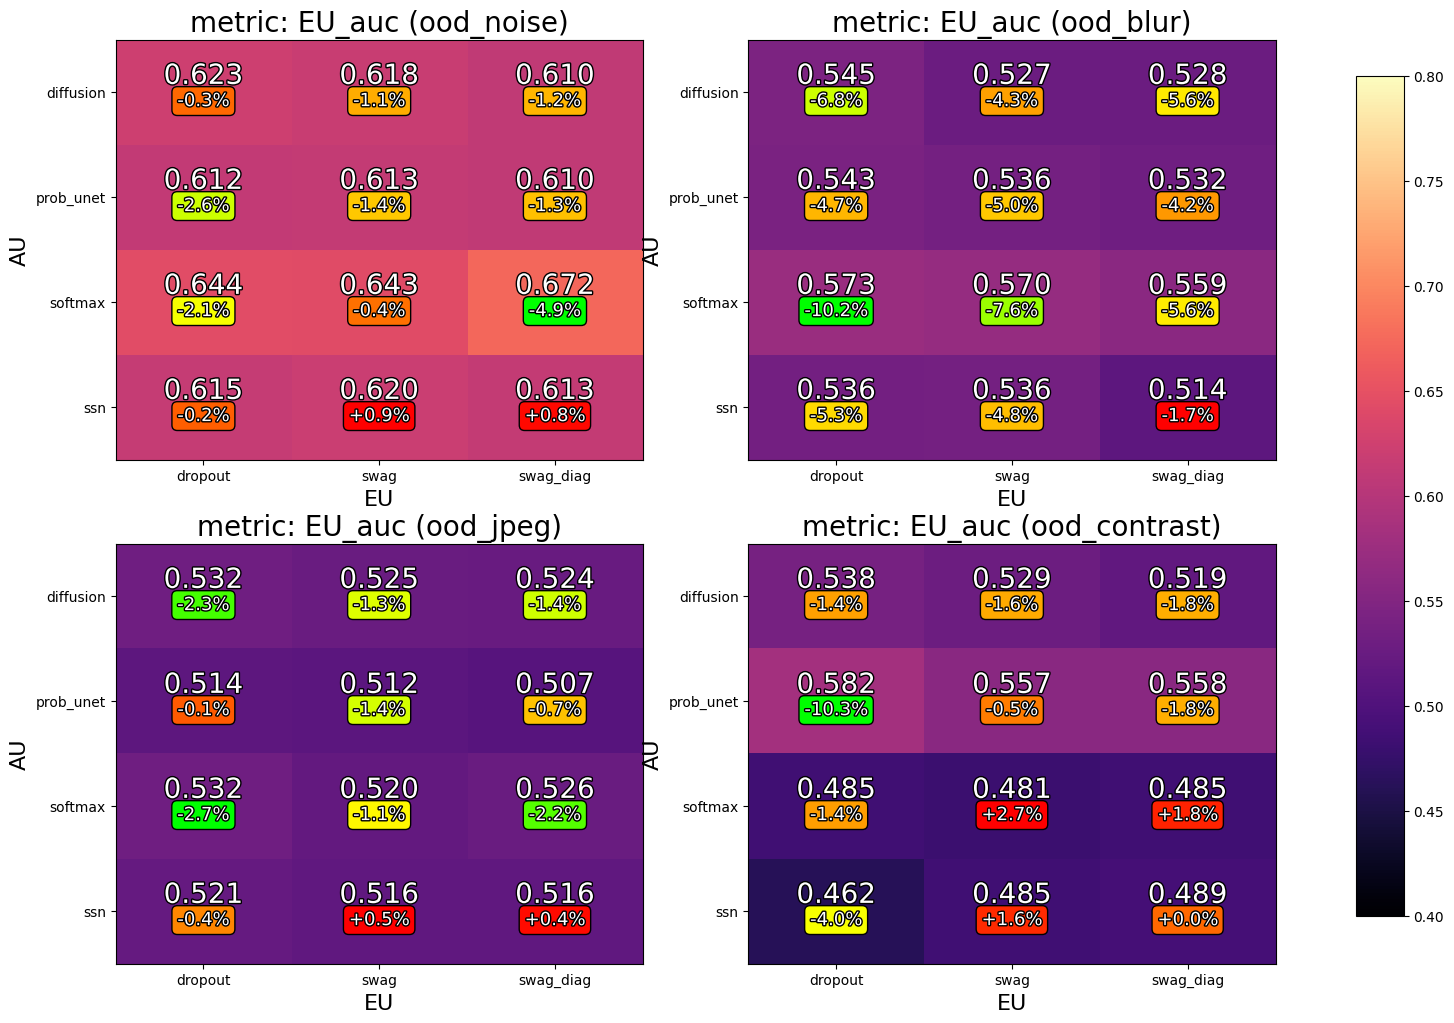

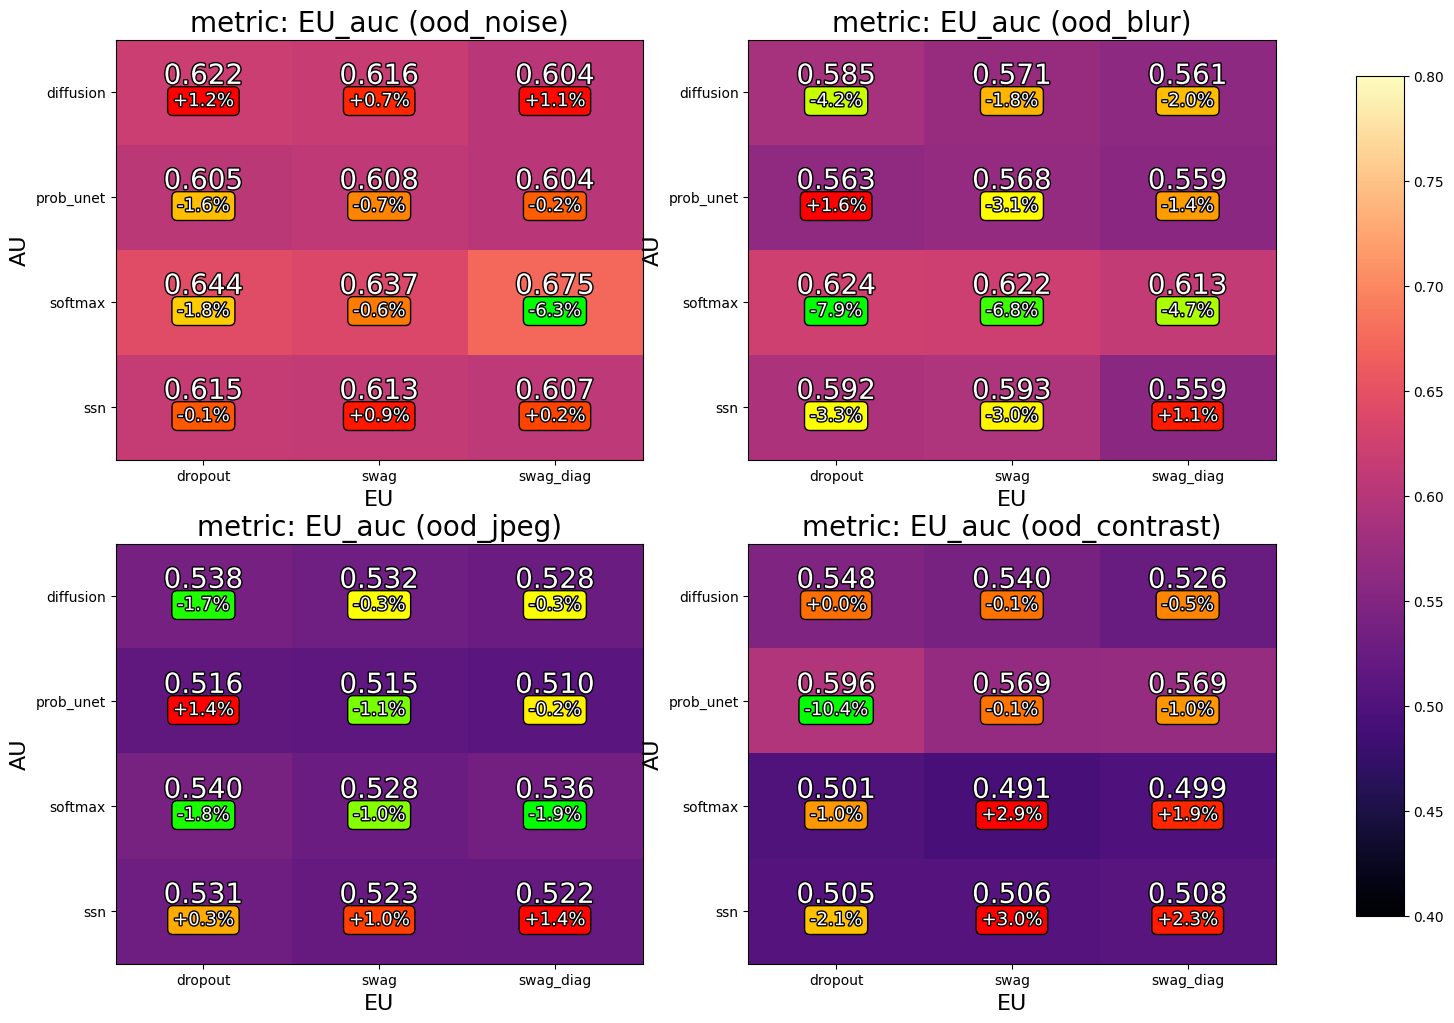

In [29]:
matrices = {}
import pandas as pd
ood_types = ["ood_noise", "ood_blur", "ood_jpeg", "ood_contrast"]
aggr_types = ['patch_level', 'image_level', 'threshold', 'area_normalized', 'border_normalized']

from helpers import load_result_table,plot_metric_matrix, plot_mm_grid
for aggr in aggr_types:
    table = load_result_table(swap_AU_EU=False,
                            formatter="{AU}_{EU}",epoch=1000,
                            loop_params = {
                                "AU": ["softmax", "ssn", "diffusion", "prob_unet"],
                                "EU": ["swag", "dropout", "swag_diag"]
                    },
                    save_path = "/home/jloch/Desktop/diff/luzern/values/saves/lidc64/test_results/",
                    aggregation_type = aggr)
    out = plot_mm_grid(table,
    kwarg_grid=[[{"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_noise","cbar_keys": ["EU_auc"]},
                {"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_blur","cbar_keys": ["EU_auc"]}],
                [{"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_jpeg","cbar_keys": ["EU_auc"]},
                {"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_contrast","cbar_keys": ["EU_auc"]}]],
                same_cbar_vals=(0.4,0.8))
    matrices[aggr] = {"ood_noise": out[0][0]["matrix"], "ood_blur": out[0][1]["matrix"], 
                      "ood_jpeg": out[1][0]["matrix"],  "ood_contrast": out[1][1]["matrix"]}



In [30]:
import numpy as np
#make a matrix of lists over aggregation types for each subkey. Each matrix is a 4x3 matrix as a pandas table
all_matrix = {}
#initalize with empty lists
for subkey in ood_types:
    all_matrix[subkey] = matrices[aggr_types[0]][subkey].copy()
    #fill the pandas table with empty lists
    all_matrix[subkey] = all_matrix[subkey].applymap(lambda x: [])
#fill the matrices with the values from each aggregation type
for aggr in aggr_types:
    for subkey in ood_types:
        for i in range(all_matrix[subkey].shape[0]):
            for j in range(all_matrix[subkey].shape[1]):
                all_matrix[subkey].iloc[i,j].append(matrices[aggr][subkey].iloc[i,j])
def gaussnorm(x):
    x = np.array(x)
    return (x - x.mean()) / x.std()
# normalize with gaussian for all lists
for subkey in ood_types:
    all_matrix[subkey] = all_matrix[subkey].applymap(lambda x: gaussnorm(x))


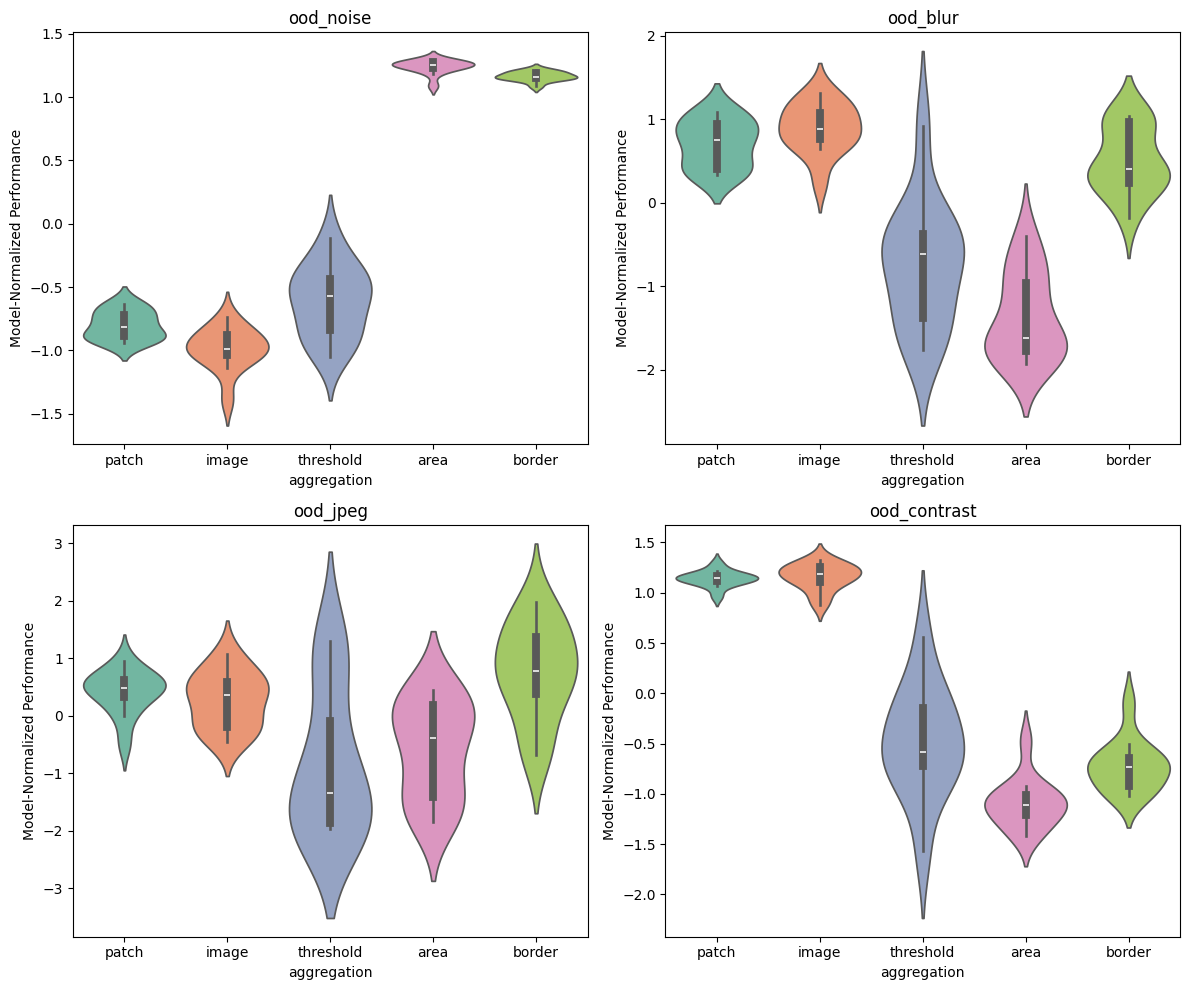

In [31]:

fig,axs = plt.subplots(2,2, figsize=(12,10))
import seaborn as sns
import pandas as pd
#make a dataframe with columns "value" and "aggr"
for i, ood_type in enumerate(ood_types):
    ax = axs[i//2, i%2]
    df = pd.DataFrame(columns=["Model-Normalized Performance", "aggregation"])
    for i, aggr in enumerate(aggr_types):
        values = []
        for j in range(all_matrix[ood_type].shape[0]):
            for k in range(all_matrix[ood_type].shape[1]):
                values.append(all_matrix[ood_type].iloc[j,k][i])
        df = pd.concat([df, pd.DataFrame({"Model-Normalized Performance": values, "aggregation": aggr})], ignore_index=True)
    # change all aggr names with lambda x: x.split("_")[0]
    df["aggregation"] = df["aggregation"].apply(lambda x: x.split("_")[0])
    sns.violinplot(x="aggregation", y="Model-Normalized Performance", data=df, palette="Set2", ax=ax, hue="aggregation", dodge=False)
    ax.set_title(ood_type)
plt.tight_layout()

/tmp/ipykernel_416195/59095297.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="aggregation", y="mean_performance", data=df, palette="Set2", ax=axs)


Text(0.5, 1.0, 'Mean Model-Normalized Performance across OOD Types')

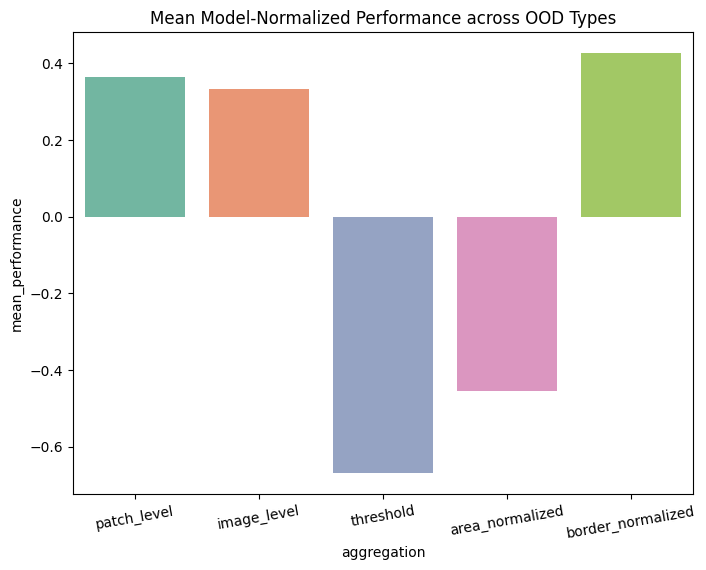

In [206]:
#make a barplot with same set2 colors where we aggregate all the mean performances to get a single number per aggr type

fig,axs = plt.subplots(1,1, figsize=(8,6))
import seaborn as sns
import pandas as pd
#make a dataframe with columns "value" and "aggr"
vals = {aggr: [] for aggr in aggr_types}
for i, ood_type in enumerate(ood_types):
    for i, aggr in enumerate(aggr_types):
        values = []
        for j in range(all_matrix[ood_type].shape[0]):
            for k in range(all_matrix[ood_type].shape[1]):
                values.append(all_matrix[ood_type].iloc[j,k][i])
        vals[aggr].append(np.mean(values))
df = pd.DataFrame({"aggregation": list(vals.keys()), "mean_performance": [np.mean(vals[aggr]) for aggr in vals.keys()]})
sns.barplot(x="aggregation", y="mean_performance", data=df, palette="Set2", ax=axs)
plt.xticks(rotation=10)
plt.title("Mean Model-Normalized Performance across OOD Types")

Text(0.5, 1.0, 'Borders')

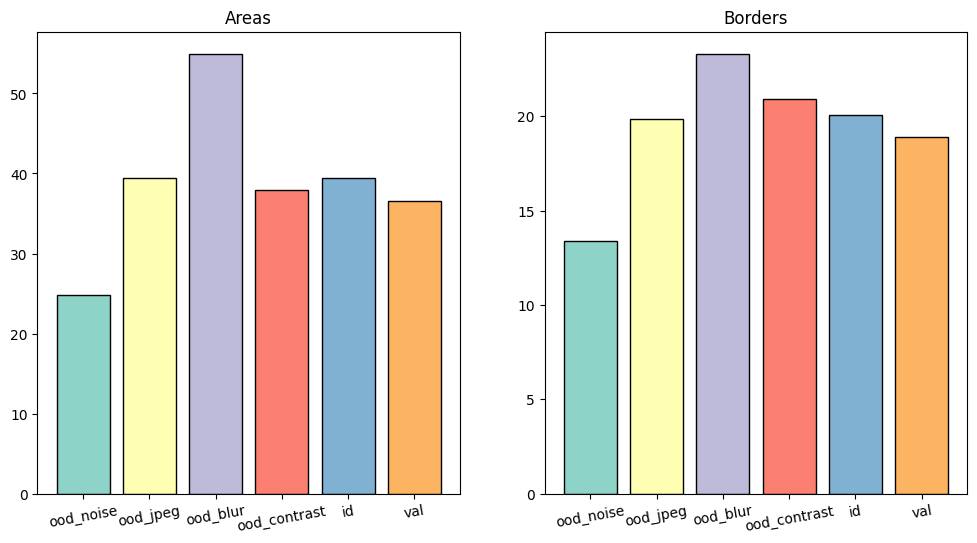

In [239]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
p = "/home/jloch/Desktop/diff/luzern/values/saves/lidc64/test_results/diffusion_swag/e1000_ema"
areas = {}
borders = {}
for file in Path(p).glob("*/area.json"):
    split = file.parts[-2]
    with open(file, "r") as f:        
        area = json.load(f)
    areas[split] = [v["area"] for v in area.values()]
    borders[split] = [v["border"] for v in area.values()]
#sort keys
areas = dict(sorted(areas.items()))
borders = dict(sorted(borders.items()))
import pandas as pd
#make a log scale dataframe with columns "value" and "split"
df_area = pd.DataFrame(columns=["value", "split"])
df_border = pd.DataFrame(columns=["value", "split"])
f = lambda x: x
for split in areas.keys():
    df_area = pd.concat([df_area, pd.DataFrame({"value": f(areas[split]), "split": split})], ignore_index=True)
    df_border = pd.concat([df_border, pd.DataFrame({"value": f(borders[split]), "split": split})], ignore_index=True)

split_names = ["ood_noise", "ood_jpeg", "ood_blur", "ood_contrast","id","val"]
mean_areas = [np.mean(areas[split]) for split in split_names]
mean_borders = [np.mean(borders[split]) for split in split_names]
#plot barplot of mean areas and borders with matplotlib
#Use set3 as colors
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(split_names, mean_areas, color=plt.cm.Set3.colors, edgecolor="black")
plt.xticks(rotation=10)
plt.title("Areas")
plt.subplot(1,2,2)
plt.bar(split_names, mean_borders, color=plt.cm.Set3.colors, edgecolor="black")
plt.xticks(rotation=10)
plt.title("Borders")

# lidc

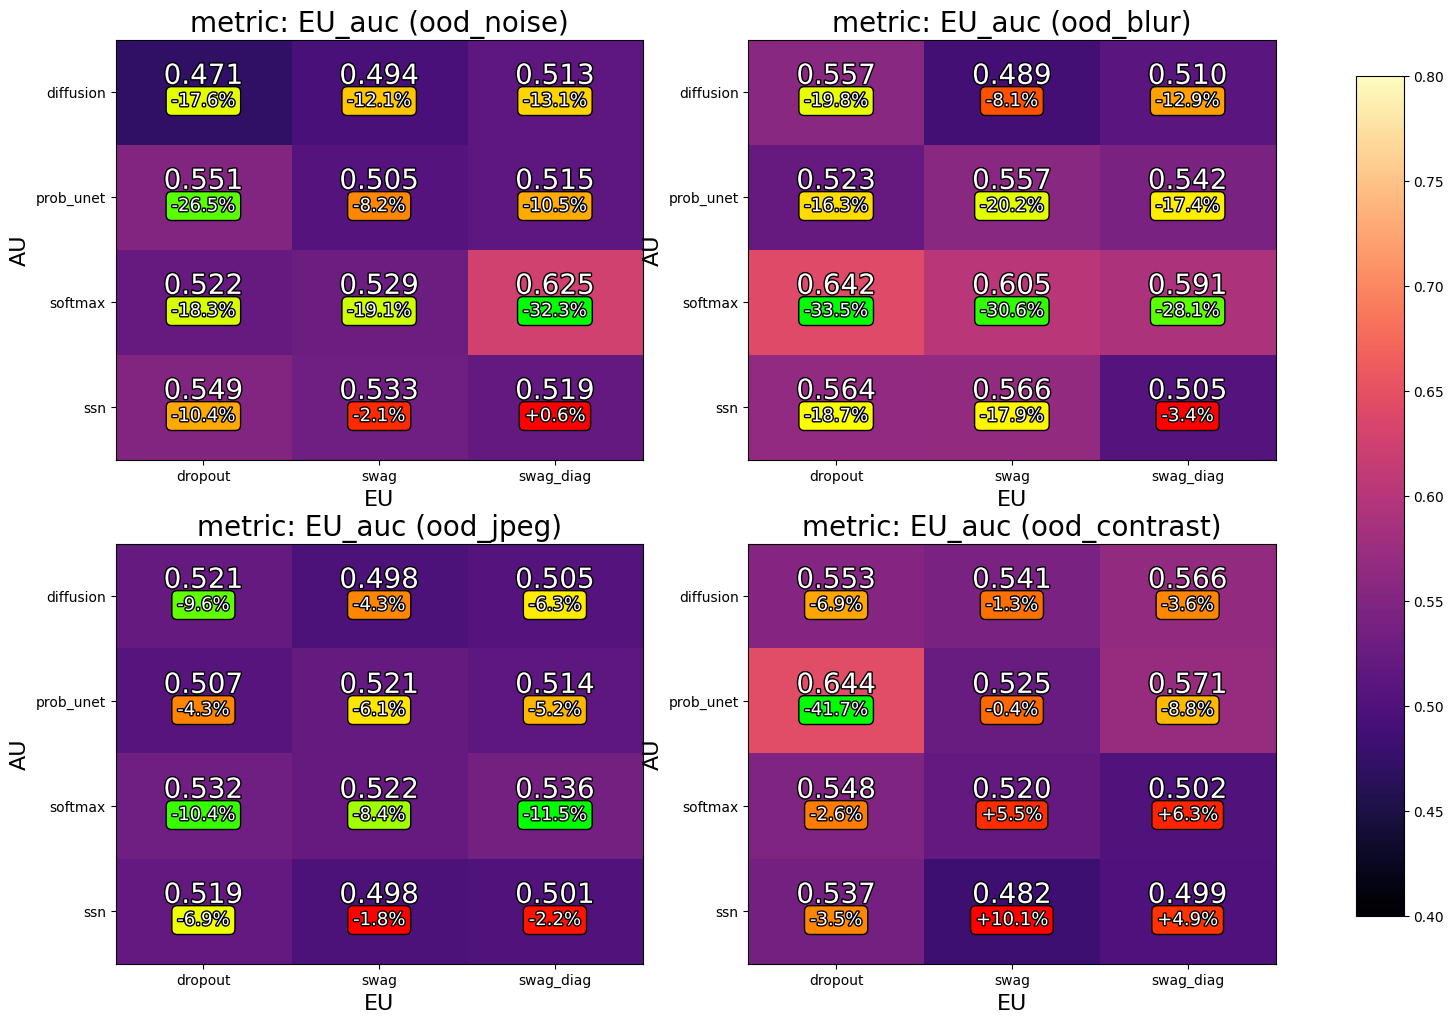

In [ ]:
from helpers import plot_mm_grid
plot_mm_grid(table,
    kwarg_grid=[[{"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_noise","cbar_keys": ["EU_auc"]},
                {"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_blur","cbar_keys": ["EU_auc"]}],
                [{"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_jpeg","cbar_keys": ["EU_auc"]},
                {"metric": "EU_auc","reldiff": "(EU-AU)_auc","subkey": "ood_contrast","cbar_keys": ["EU_auc"]}]],
                same_cbar_vals=(0.4,0.8))

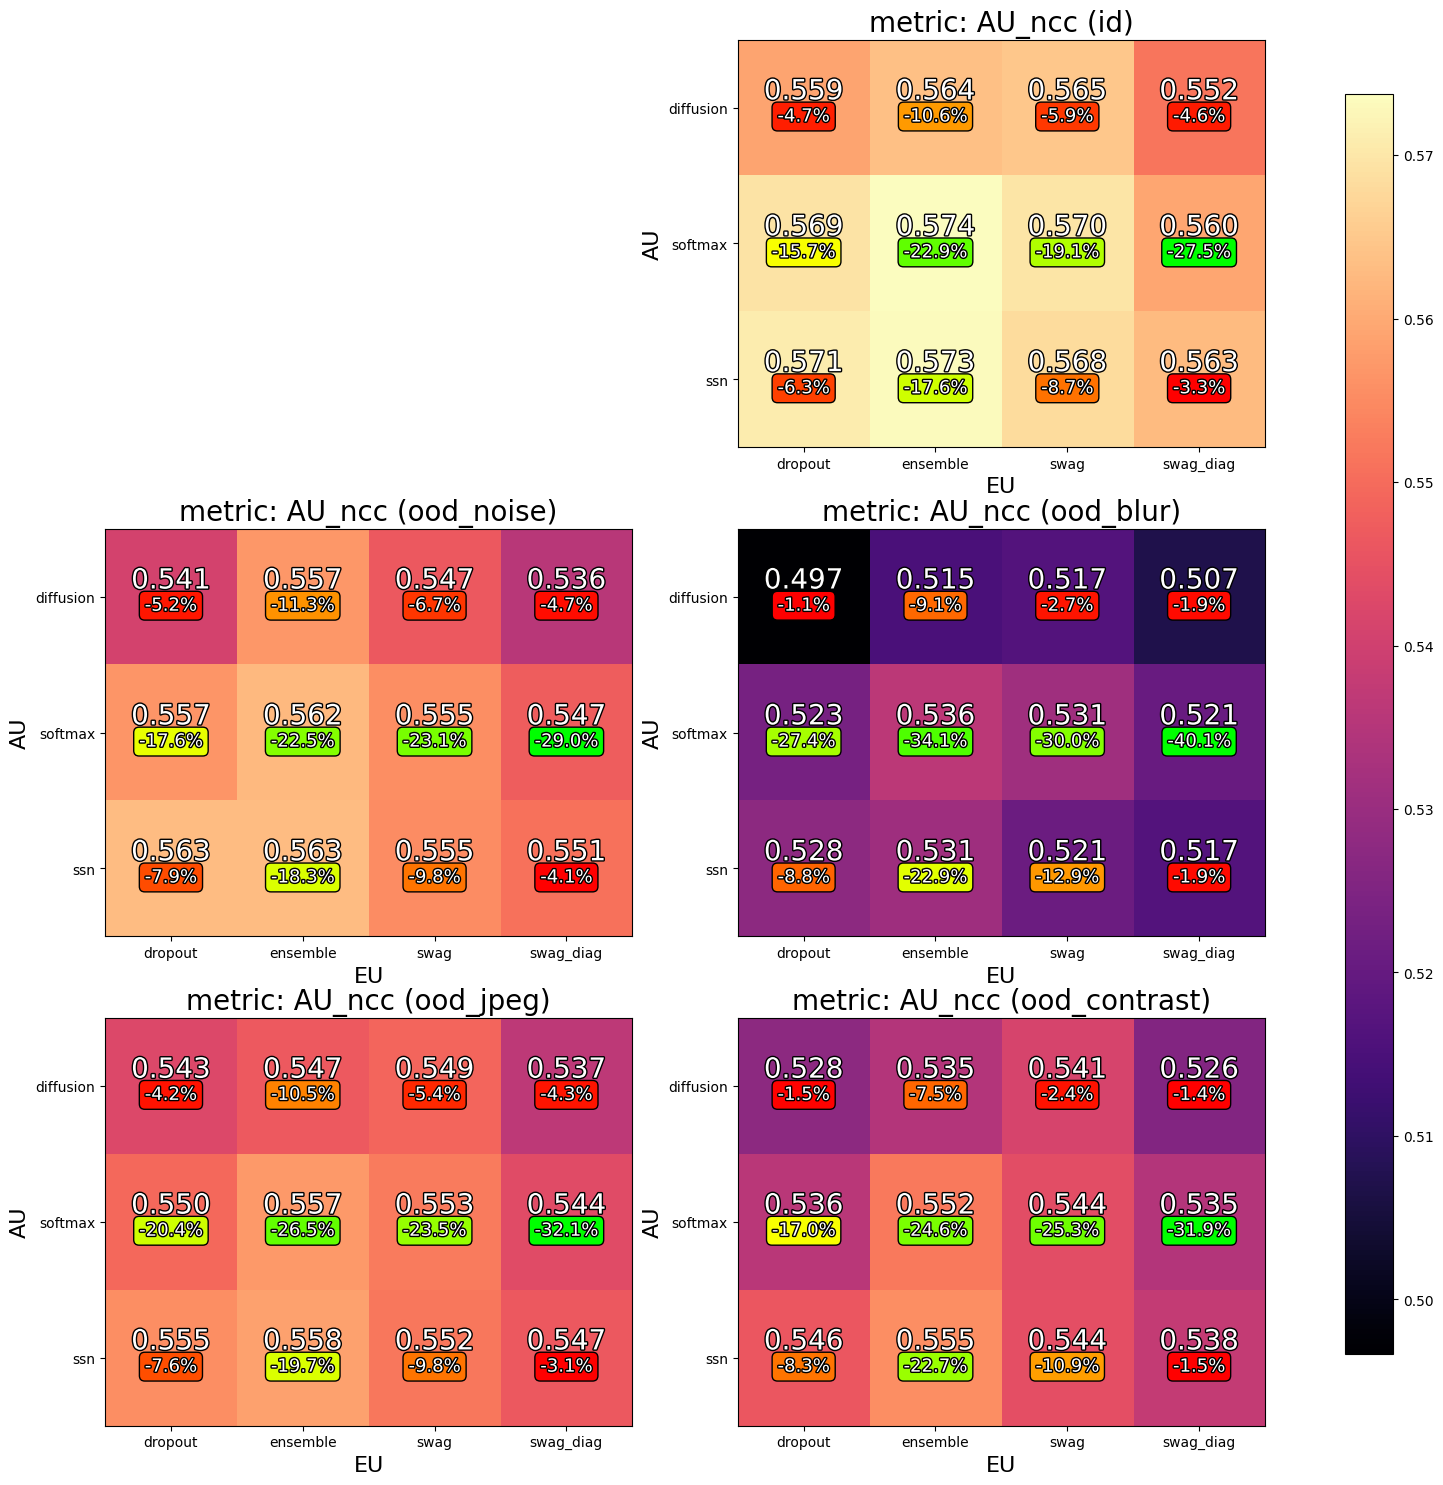

In [51]:
plot_mm_grid(table,
    kwarg_grid=[[None,
                {"metric": "AU_ncc","reldiff": "(AU-EU)_ncc","subkey": "id","cbar_keys": ["AU_ncc"]}],
                [{"metric": "AU_ncc","reldiff": "(AU-EU)_ncc","subkey": "ood_noise","cbar_keys": ["AU_ncc"]},
                {"metric": "AU_ncc","reldiff": "(AU-EU)_ncc","subkey": "ood_blur","cbar_keys": ["AU_ncc"]}],
                [{"metric": "AU_ncc","reldiff": "(AU-EU)_ncc","subkey": "ood_jpeg","cbar_keys": ["AU_ncc"]},
                {"metric": "AU_ncc","reldiff": "(AU-EU)_ncc","subkey": "ood_contrast","cbar_keys": ["AU_ncc"]}]])

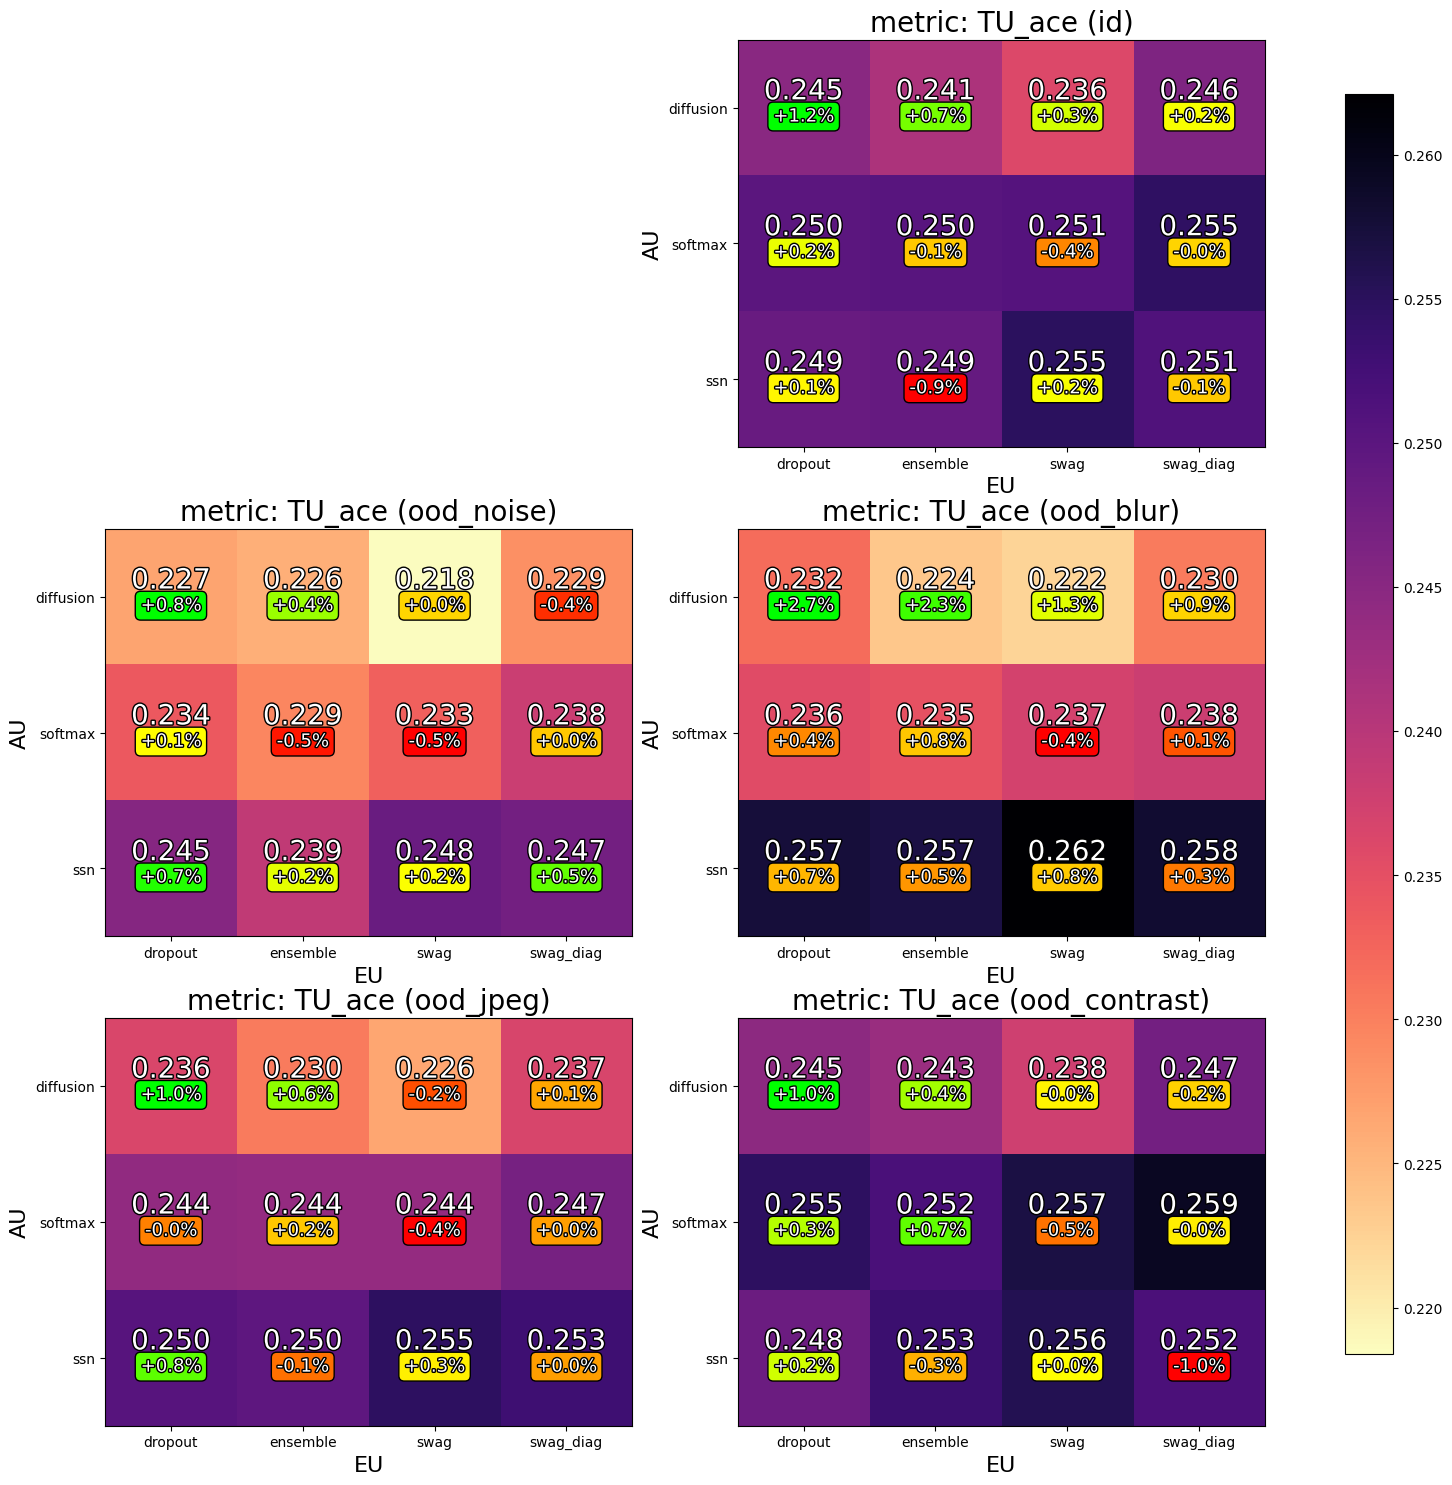

In [ ]:
plot_mm_grid(table,
    kwarg_grid=[[None,
                {"metric": "TU_ace","reldiff": "(min(AU,EU)-TU)_ace","subkey": "id","cbar_keys": ["TU_ace"]}],
                [{"metric": "TU_ace","reldiff": "(min(AU,EU)-TU)_ace","subkey": "ood_noise","cbar_keys": ["TU_ace"]},
                {"metric": "TU_ace","reldiff": "(min(AU,EU)-TU)_ace","subkey": "ood_blur","cbar_keys": ["TU_ace"]}],
                [{"metric": "TU_ace","reldiff": "(min(AU,EU)-TU)_ace","subkey": "ood_jpeg","cbar_keys": ["TU_ace"]},
                {"metric": "TU_ace","reldiff": "(min(AU,EU)-TU)_ace","subkey": "ood_contrast","cbar_keys": ["TU_ace"]}]])

# grid unc plot

Seed set to 120


SETTING GLOBAL SEED TO 120
Dataset: lidc2d id_test - 2790 images
saving to results dir /home/jloch/Desktop/diff/luzern/values/saves/lidc64/test_results/ssn_dropout/e1000/id


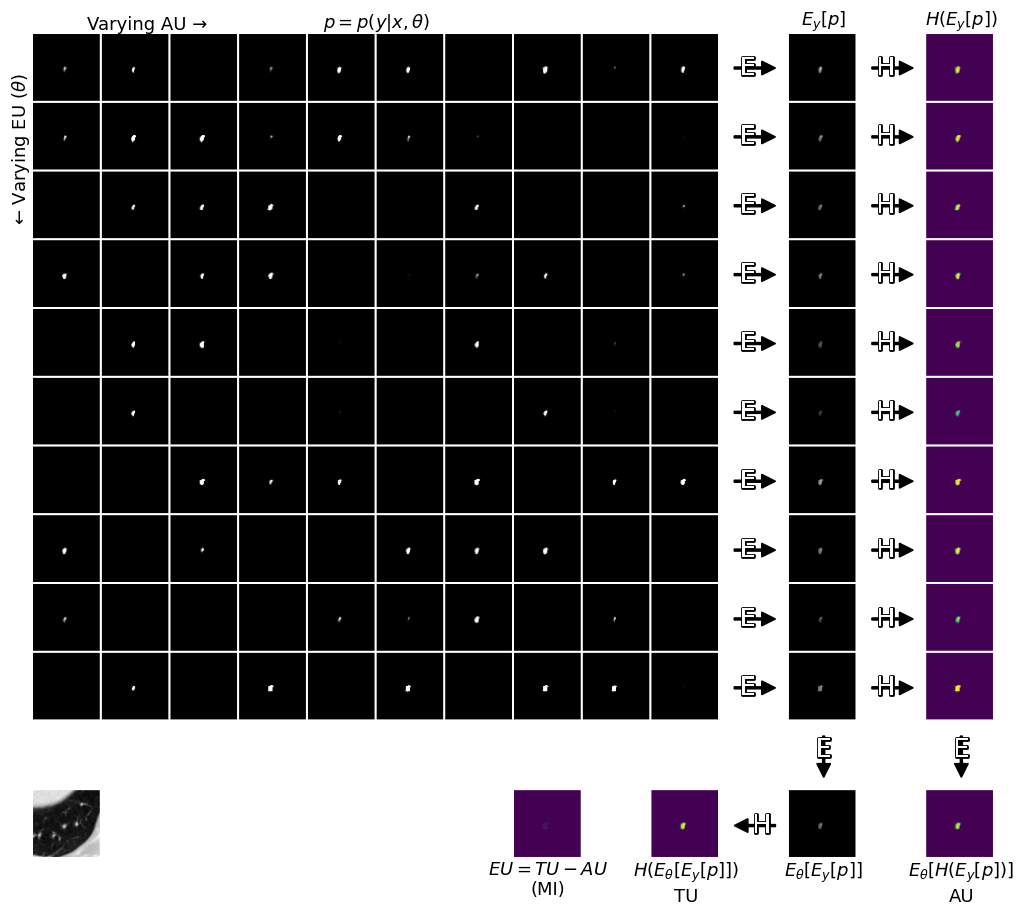

In [281]:

from helpers import plot_pred_grid, pred_grid_computation
p = "/home/jloch/Desktop/diff/luzern/values/saves/lidc64/ssn_dropout/checkpoints/last.ckpt"
images, batch0 = pred_grid_computation(ckpt_path = p,
                          split = "id_test",
                          test_batch_size = 1)
plot_pred_grid(images, batch0, 0)

Seed set to 120


SETTING GLOBAL SEED TO 120
Dataset: chaksu64 id_test - 264 images
saving to results dir /home/jloch/Desktop/diff/luzern/values/saves/chaksu64/test_results/prob_unet_dropout/e640/id


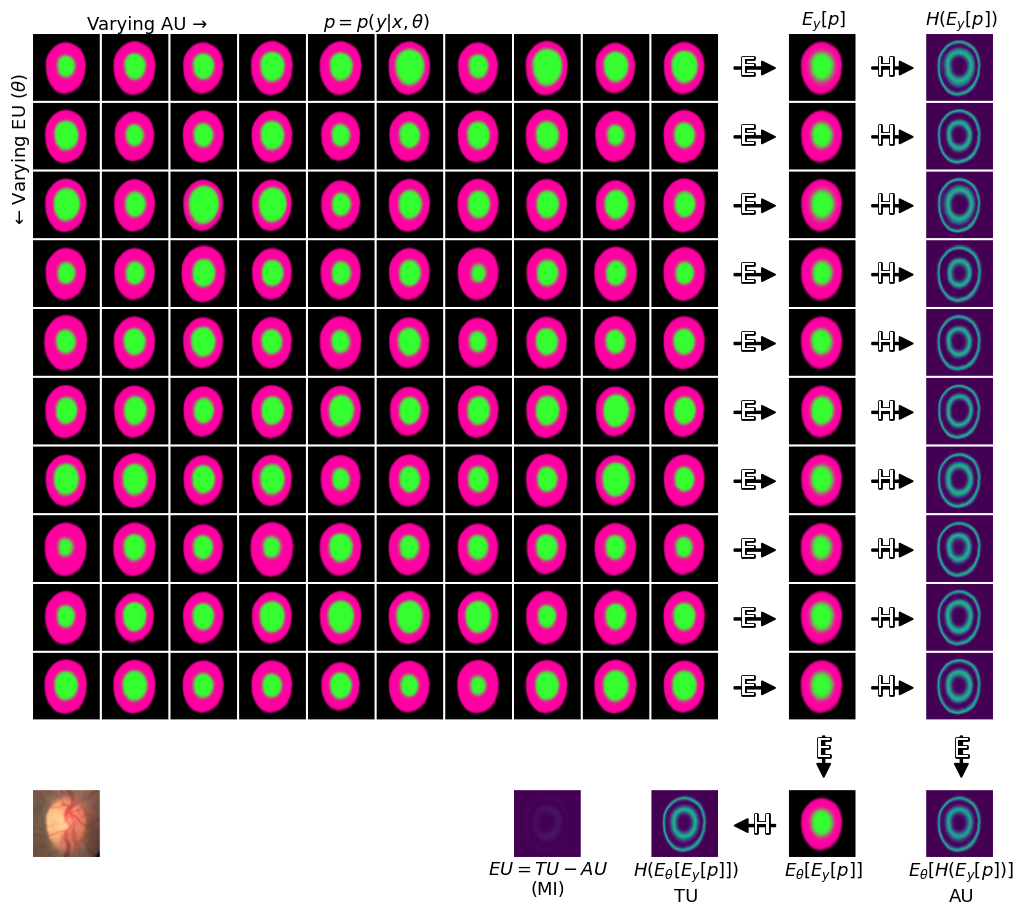

In [310]:

from helpers import plot_pred_grid, pred_grid_computation
p = "/home/jloch/Desktop/diff/luzern/values/saves/chaksu64/prob_unet_dropout/checkpoints/last.ckpt"
images, batch0 = pred_grid_computation(ckpt_path = p,
                          split = "id_test",
                          test_batch_size = 1)
plot_pred_grid(images, batch0, 0)

In [302]:
batch0["softmax_pred"].shape

torch.Size([10, 1, 3, 64, 64])

In [131]:
plot_pred_grid(images, batch0, 11, s=1, crop_unused=False, entropy_cmap="viridis")

torch.Size([1, 64, 64, 3])
torch.Size([1, 64, 64, 3])


ValueError: Expected a single-channel 2D tensor for grayscale conversion.